# Exploratory Data Analysis: Spatiotemporal Matrix

This notebook verifies the "Physics" of the constructed spatiotemporal tensor.
We check for:
1. **Linear Growth:** Headways should increase linearly (0, 1, 2...) until a train arrives.
2. **Reset:** Headways should drop to 0 upon train arrival.
3. **Movement:** Trains should appear as diagonal "valleys" of 0s moving across stations over time.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MATRIX_PATH = "../data/headway_matrix_full.npy"
STATION_PATH = "../data/a_line_station_distances.csv"
SCHEDULE_PATH = "../data/schedule_matrix_full.npy"

# Load Data
print("Loading Data...")
data = np.load(MATRIX_PATH)
schedule = np.load(SCHEDULE_PATH)
station_map = pd.read_csv(STATION_PATH)

print(f"Headway Matrix Shape: {data.shape}")
print(f"Schedule Matrix Shape: {schedule.shape}")
print(f"Stations: {len(station_map)}")


Loading Data...
Headway Matrix Shape: (264211, 156, 2, 1)
Schedule Matrix Shape: (264211, 2, 1)
Stations: 156


## 1. Verify Physics (Sawtooth Wave)
We plot the time series for a single station. It should look like a sawtooth wave.


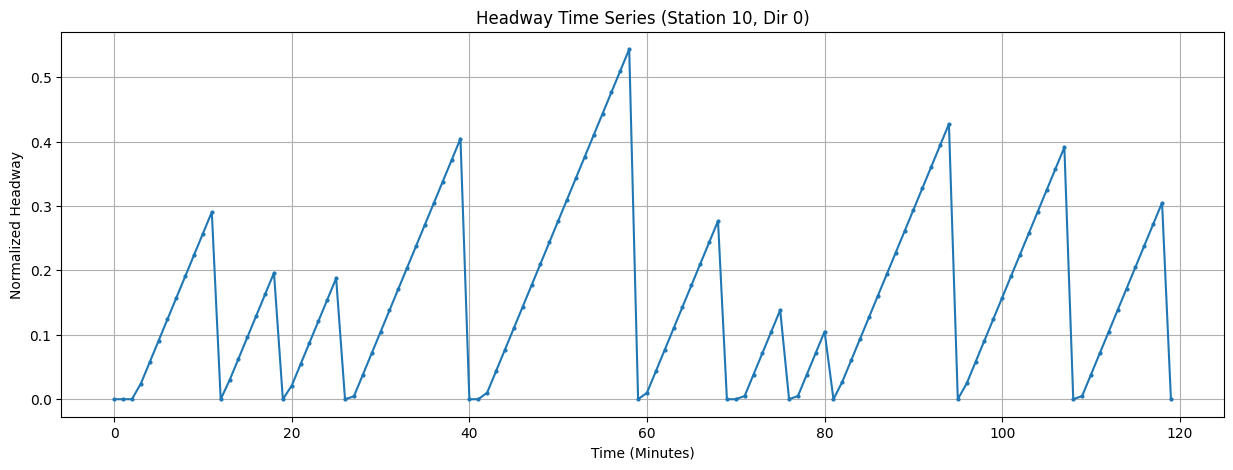

First 20 values:
[0.         0.         0.         0.02388889 0.05722222 0.09055556
 0.12388889 0.15722222 0.19055556 0.22388889 0.25722222 0.29055556
 0.         0.02944444 0.06277778 0.09611111 0.12944444 0.16277778
 0.19611111 0.        ]


In [3]:
# Select a station (e.g., index 10) and direction 0 (Northbound)
station_idx = 10
direction_idx = 0
time_steps = 120 # 2 hours

# Extract series
# Shape is (Time, Station, Direction, 1)
series = data[:time_steps, station_idx, direction_idx, 0]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(series, marker='o', markersize=2)
plt.title(f"Headway Time Series (Station {station_idx}, Dir {direction_idx})")
plt.xlabel("Time (Minutes)")
plt.ylabel("Normalized Headway")
plt.grid(True)
plt.show()

# Check values
print("First 20 values:")
print(series[:20])


## 2. Verify Train Movement (Space-Time Heatmap)
We plot a heatmap where X=Station, Y=Time.
Trains should appear as dark lines (low headway) moving across stations.

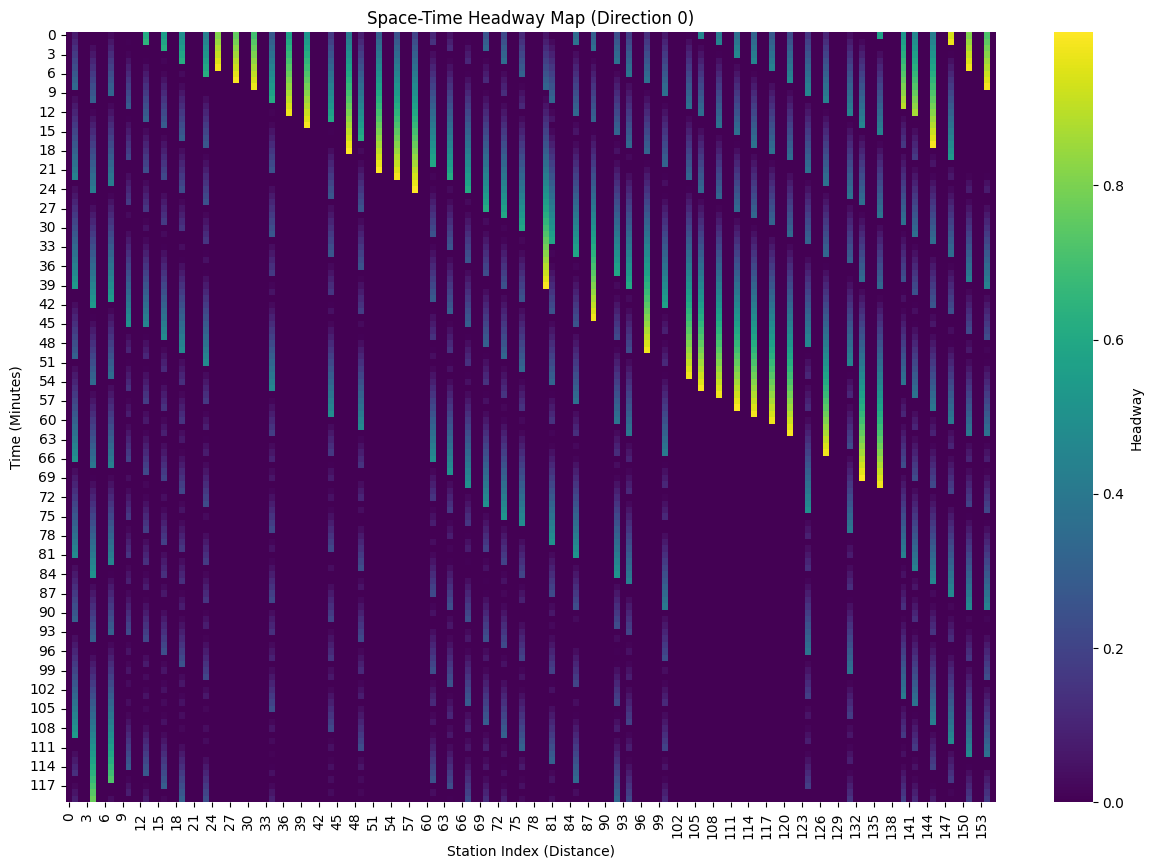

In [4]:
# Select a time window
start_t = 600 # 10:00 AM approx
end_t = 720   # 12:00 PM approx
direction_idx = 0 # Northbound

# Extract slice: (Time, Station)
heatmap_data = data[start_t:end_t, :, direction_idx, 0]

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={'label': 'Headway'})
plt.title(f"Space-Time Headway Map (Direction {direction_idx})")
plt.xlabel("Station Index (Distance)")
plt.ylabel("Time (Minutes)")
plt.show()